In [86]:
from astropy.io import fits
import os
import glob
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

## Opening a random .fits file from Unzipped JADES spectra to see what's inside

In [87]:
# Specify the path to your FITS file
fits_file = '/Users/aryanahaghjoo/Documents/GitHub/super_resolution/data/JADES/JADES_spectra_unzipped/hlsp_jades_jwst_nirspec_clear-prism/hlsp_jades_jwst_nirspec_goods-n-mediumhst-00000604_clear-prism_v1.0_s2d.fits'

# Open the FITS file
with fits.open(fits_file) as hdul:
    # Print the FITS file structure
    hdul.info()
    
    # Access the primary HDU (Header Data Unit)
    primary_hdu = hdul[0]
    
    # Print the header
    print("\nHeader of the Primary HDU:")
    print(repr(primary_hdu.header))
    
    # Access the data (if it's an image)
    if primary_hdu.data is not None:
        print("\nData shape:", primary_hdu.data.shape)

    # If there's an extension (e.g., table), access it
    if len(hdul) > 1:
        table_hdu = hdul[1]
        print("\nHeader of Extension HDU:")
        print(repr(table_hdu.header))
        print("\nData in Extension HDU (First 5 Rows):")
        print(table_hdu.data[:5])

Filename: /Users/aryanahaghjoo/Documents/GitHub/super_resolution/data/JADES/JADES_spectra_unzipped/hlsp_jades_jwst_nirspec_clear-prism/hlsp_jades_jwst_nirspec_goods-n-mediumhst-00000604_clear-prism_v1.0_s2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      34   ()      
  1  FLUX          1 ImageHDU         9   (674, 27)   float64   
  2  FLUX_ERR      1 ImageHDU         9   (674, 27)   float64   
  3  WAVELENGTH    1 ImageHDU         8   (674,)   float64   
  4  RA            1 ImageHDU         9   (674, 27)   float64   
  5  DEC           1 ImageHDU         9   (674, 27)   float64   
  6  ASDF          1 BinTableHDU      9   0R x 0C   []   

Header of the Primary HDU:
SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =               

## 1. Extracting Spectrum from "prism"

In [88]:
# Directory containing your FITS files with 1D spectra
fits_dir = '/Users/aryanahaghjoo/Documents/GitHub/super_resolution/data/JADES/JADES_spectra_unzipped/hlsp_jades_jwst_nirspec_clear-prism'
# Collect both lowercase and uppercase file extensions
fits_files = glob.glob(os.path.join(fits_dir, '*.fits')) + glob.glob(os.path.join(fits_dir, '*.FITS'))

data_list = []

for file in tqdm(fits_files, desc="Processing FITS files"):
    with fits.open(file) as hdul:
        # Search for the EXTRACT1D extension
        extract1d_hdu = None
        for hdu in hdul:
            if hdu.header.get('EXTNAME', '').strip().upper() == 'EXTRACT1D':
                extract1d_hdu = hdu
                break

        # Skip files that are not 1D spectra
        if extract1d_hdu is None:
            continue

        # Confirm the extension is a table with columns
        if not hasattr(extract1d_hdu, 'columns'):
            print(f"Warning: 'EXTRACT1D' in {os.path.basename(file)} is not a table. Skipping file.")
            continue

        table_data = extract1d_hdu.data
        available_columns = [col.upper() for col in extract1d_hdu.columns.names]
        required_columns = ['WAVELENGTH', 'FLUX', 'FLUX_ERR']
        if not all(col in available_columns for col in required_columns):
            print(f"Warning: Missing required columns in {os.path.basename(file)}. Skipping file.")
            continue

        # Extract data columns
        wavelength = table_data['WAVELENGTH']
        flux = table_data['FLUX']
        flux_err = table_data['FLUX_ERR']

        data_list.append({
            'file_name': os.path.basename(file),
            'WAVELENGTH': wavelength,
            'FLUX': flux,
            'FLUX_ERR': flux_err
        })

# Create a DataFrame where each row corresponds to a file
df_prism= pd.DataFrame(data_list)
#df_prism.to_csv('/Users/aryanahaghjoo/Documents/GitHub/super_resolution/toy_model/JADES_spectra_dataframe/prism.csv', index=False)

Processing FITS files: 100%|██████████| 7504/7504 [00:06<00:00, 1101.64it/s]


In [89]:
df_prism

,file_name,WAVELENGTH,FLUX,FLUX_ERR
0,hlsp_jades_jwst_nirspec_goods-s-mediumjwst1180...,"[0.6025500540697117, 0.6051543430096333, 0.607...","[nan, 1.6558568411742087e-20, 1.32674916986150...","[nan, 1.9065509910426825e-20, 1.82963763546714..."
1,hlsp_jades_jwst_nirspec_goods-n-mediumhst-0002...,"[0.6025500540697117, 0.6051543430096333, 0.607...","[nan, 2.01184890526121e-20, 4.176809182277331e...","[nan, 1.7326892567333e-20, 1.6103023576710562e..."
2,hlsp_jades_jwst_nirspec_goods-s-mediumhst-0000...,"[0.6025500540697117, 0.6051543430096333, 0.607...","[nan, 2.5894512549419576e-20, 2.87361198826301...","[nan, 4.630180953582602e-20, 4.404882103455821..."
3,hlsp_jades_jwst_nirspec_goods-s-mediumhst-0004...,"[0.6025500540697117, 0.6051543430096333, 0.607...","[nan, 2.4834252066419896e-20, 2.27124545700521...","[nan, 3.01149165917404e-20, 2.5857642973558054..."
4,hlsp_jades_jwst_nirspec_goods-n-mediumjwst-000...,"[0.6025500540697117, 0.6051543430096333, 0.607...","[1.7628827558841336e-20, 2.129762538605096e-20...","[4.5999273483926965e-20, 1.7484532328649386e-2..."
...,...,...,...,...
3747,hlsp_jades_jwst_nirspec_goods-s-mediumhst-0000...,"[0.6025500540697117, 0.6051543430096333, 0.607...","[-6.019837867354967e-19, -2.866506782807916e-1...","[7.4240623455505e-19, 3.7582540039241757e-19, ..."
3748,hlsp_jades_jwst_nirspec_goods-s-mediumjwst-000...,"[0.6025500540697117, 0.6051543430096333, 0.607...","[nan, 2.63448617724546e-20, 4.533356832237835e...","[nan, 2.1416511199229643e-20, 2.02147796931549..."
3749,hlsp_jades_jwst_nirspec_goods-s-mediumjwst-000...,"[0.6025500540697117, 0.6051543430096333, 0.607...","[nan, 2.303869901869643e-17, -4.56541470833669...","[nan, 3.290906060147686e-18, 2.796700111192446..."
3750,hlsp_jades_jwst_nirspec_goods-n-mediumjwst-000...,"[0.6025500540697117, 0.6051543430096333, 0.607...","[nan, -1.8616483994452673e-20, -2.899215344097...","[nan, 1.6998804342523424e-20, 1.55563771351816..."


In [90]:
def classify_nan_positions(arr):
    """
    Classify NaN positions in a 1D numpy array.

    Returns:
      - 'no_nans' if there are no NaN values.
      - 'all_nans' if the entire array is NaN.
      - 'trailing_nans' if all NaNs occur only after the last valid (non-NaN) value.
      - 'middle_nans' if any NaN occurs before the last valid value.
    """
    nan_indices = np.where(np.isnan(arr))[0]
    if len(nan_indices) == 0:
        return 'no_nans'
    
    valid_indices = np.where(~np.isnan(arr))[0]
    if len(valid_indices) == 0:
        return 'all_nans'
    
    last_valid = valid_indices[-1]
    # If all NaN indices are strictly greater than the last valid index,
    # then NaNs are only trailing.
    if np.all(nan_indices > last_valid):
        return 'trailing_nans'
    else:
        return 'middle_nans'

In [91]:
# Count NaN entries in each file's FLUX and FLUX_ERR arrays
df_prism['nan_in_flux'] = df_prism['FLUX'].apply(lambda arr: np.isnan(arr).sum())
df_prism['nan_in_flux_err'] = df_prism['FLUX_ERR'].apply(lambda arr: np.isnan(arr).sum())

# Display the count per file
#print(df_prism[['file_name', 'nan_in_flux', 'nan_in_flux_err']])

# Sum across all files to get the total number of NaN entries
total_nan_flux = df_prism['nan_in_flux'].sum()
total_nan_flux_err = df_prism['nan_in_flux_err'].sum()

print("Total NaNs in FLUX:", total_nan_flux)
print("Total NaNs in FLUX_ERR:", total_nan_flux_err)

# Apply the classification to your DataFrame columns:
df_prism['flux_nan_position'] = df_prism['FLUX'].apply(classify_nan_positions)
df_prism['flux_err_nan_position'] = df_prism['FLUX_ERR'].apply(classify_nan_positions)

# Optionally, count the occurrences in each category:
flux_counts = df_prism['flux_nan_position'].value_counts()
flux_err_counts = df_prism['flux_err_nan_position'].value_counts()

print("NaN positions in FLUX:")
print(flux_counts)
print("\nNaN positions in FLUX_ERR:")
print(flux_err_counts)

# You can also separate the files based on classification, for example:
df_prism_middle = df_prism[(df_prism['flux_nan_position'] == 'middle_nans') | (df_prism['flux_err_nan_position'] == 'middle_nans')]
df_prism_trailing = df_prism[(df_prism['flux_nan_position'] == 'trailing_nans') & (df_prism['flux_err_nan_position'] == 'trailing_nans')]

#print("\nFiles with NaNs in the middle:")
#print(df_prism_middle[['file_name', 'flux_nan_position', 'flux_err_nan_position']])
#print("\nFiles with only trailing NaNs:")
#print(df_prism_trailing[['file_name', 'flux_nan_position', 'flux_err_nan_position']])

Total NaNs in FLUX: 28487
Total NaNs in FLUX_ERR: 28487
NaN positions in FLUX:
flux_nan_position
middle_nans      3028
trailing_nans     724
Name: count, dtype: int64

NaN positions in FLUX_ERR:
flux_err_nan_position
middle_nans      3028
trailing_nans     724
Name: count, dtype: int64


## 2. Extracting Spectrum from "g140m"

In [92]:
# Directory containing your FITS files with 1D spectra
fits_dir = '/Users/aryanahaghjoo/Documents/GitHub/super_resolution/data/JADES/JADES_spectra_unzipped/hlsp_jades_jwst_nirspec_f070lp-g140m'
# Collect both lowercase and uppercase file extensions
fits_files = glob.glob(os.path.join(fits_dir, '*.fits')) + glob.glob(os.path.join(fits_dir, '*.FITS'))

data_list = []

for file in tqdm(fits_files, desc="Processing FITS files"):
    with fits.open(file) as hdul:
        # Search for the EXTRACT1D extension
        extract1d_hdu = None
        for hdu in hdul:
            if hdu.header.get('EXTNAME', '').strip().upper() == 'EXTRACT1D':
                extract1d_hdu = hdu
                break

        # Skip files that are not 1D spectra
        if extract1d_hdu is None:
            continue

        # Confirm the extension is a table with columns
        if not hasattr(extract1d_hdu, 'columns'):
            print(f"Warning: 'EXTRACT1D' in {os.path.basename(file)} is not a table. Skipping file.")
            continue

        table_data = extract1d_hdu.data
        available_columns = [col.upper() for col in extract1d_hdu.columns.names]
        required_columns = ['WAVELENGTH', 'FLUX', 'FLUX_ERR']
        if not all(col in available_columns for col in required_columns):
            print(f"Warning: Missing required columns in {os.path.basename(file)}. Skipping file.")
            continue

        # Extract data columns
        wavelength = table_data['WAVELENGTH']
        flux = table_data['FLUX']
        flux_err = table_data['FLUX_ERR']

        data_list.append({
            'file_name': os.path.basename(file),
            'WAVELENGTH': wavelength,
            'FLUX': flux,
            'FLUX_ERR': flux_err
        })

# Create a DataFrame where each row corresponds to a file
df_g140m= pd.DataFrame(data_list)
#df_g140m.to_csv('/Users/aryanahaghjoo/Documents/GitHub/super_resolution/toy_model/JADES_spectra_dataframe/g140m.csv', index=False)

Processing FITS files: 100%|██████████| 6968/6968 [00:06<00:00, 1098.52it/s]


In [93]:
df_g140m

,file_name,WAVELENGTH,FLUX,FLUX_ERR
0,hlsp_jades_jwst_nirspec_goods-s-mediumhst-0003...,"[0.7, 0.7006363639999998, 0.7012727279999998, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,hlsp_jades_jwst_nirspec_goods-n-mediumhst-0002...,"[0.7, 0.700636364, 0.701272728, 0.701909092, 0...","[nan, 1.904705971881416e-18, -1.72687355738843...","[nan, 1.779430888631721e-18, 1.093628082287658..."
2,hlsp_jades_jwst_nirspec_goods-n-mediumjwst-000...,"[0.7, 0.7006363639999998, 0.7012727279999998, ...","[nan, 8.839861759660464e-19, 1.561907919706200...","[nan, 7.400520285434298e-19, 5.709756593043696..."
3,hlsp_jades_jwst_nirspec_goods-s-mediumhst-0000...,"[0.7, 0.7006363639999998, 0.7012727279999998, ...","[nan, 4.915879528171848e-18, -2.16983726468976...","[nan, 1.3665228764058456e-17, 1.45810399650653..."
4,hlsp_jades_jwst_nirspec_goods-s-mediumjwst-000...,"[0.7, 0.7006363639999998, 0.7012727279999998, ...","[nan, 2.274983177572615e-18, -1.96874427194249...","[nan, 1.7125112421836307e-18, 9.96926796940824..."
...,...,...,...,...
3479,hlsp_jades_jwst_nirspec_goods-s-mediumjwst-100...,"[0.7, 0.7006363639999998, 0.7012727279999998, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3480,hlsp_jades_jwst_nirspec_goods-n-mediumhst-0002...,"[0.7, 0.700636364, 0.701272728, 0.701909092, 0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3481,hlsp_jades_jwst_nirspec_goods-s-mediumjwst1180...,"[0.7, 0.7006363639999998, 0.7012727279999998, ...","[nan, 1.2544640856278083e-18, 6.25242656262476...","[nan, 6.042307411575745e-19, 5.691065428089047..."
3482,hlsp_jades_jwst_nirspec_goods-n-mediumjwst-100...,"[0.7, 0.7006363639999998, 0.7012727279999998, ...","[nan, -8.785378229780268e-19, -8.4845265914481...","[nan, 1.090366518990506e-18, 5.952871357913609..."


In [94]:
# Count NaN entries in each file's FLUX and FLUX_ERR arrays
df_g140m['nan_in_flux'] = df_g140m['FLUX'].apply(lambda arr: np.isnan(arr).sum())
df_g140m['nan_in_flux_err'] = df_g140m['FLUX_ERR'].apply(lambda arr: np.isnan(arr).sum())

# Display the count per file
#print(df_prism[['file_name', 'nan_in_flux', 'nan_in_flux_err']])

# Sum across all files to get the total number of NaN entries
total_nan_flux = df_g140m['nan_in_flux'].sum()
total_nan_flux_err = df_g140m['nan_in_flux_err'].sum()

print("Total NaNs in FLUX:", total_nan_flux)
print("Total NaNs in FLUX_ERR:", total_nan_flux_err)

# Apply the classification to your DataFrame columns:
df_g140m['flux_nan_position'] = df_g140m['FLUX'].apply(classify_nan_positions)
df_g140m['flux_err_nan_position'] = df_g140m['FLUX_ERR'].apply(classify_nan_positions)

# Optionally, count the occurrences in each category:
flux_counts = df_g140m['flux_nan_position'].value_counts()
flux_err_counts = df_g140m['flux_err_nan_position'].value_counts()

print("NaN positions in FLUX:")
print(flux_counts)
print("\nNaN positions in FLUX_ERR:")
print(flux_err_counts)

# You can also separate the files based on classification, for example:
df_g140m_middle = df_g140m[(df_g140m['flux_nan_position'] == 'middle_nans') | (df_g140m['flux_err_nan_position'] == 'middle_nans')]
df_g140m_trailing = df_g140m[(df_g140m['flux_nan_position'] == 'trailing_nans') & (df_g140m['flux_err_nan_position'] == 'trailing_nans')]

#print("\nFiles with NaNs in the middle:")
#print(df_prism_middle[['file_name', 'flux_nan_position', 'flux_err_nan_position']])
#print("\nFiles with only trailing NaNs:")
#print(df_prism_trailing[['file_name', 'flux_nan_position', 'flux_err_nan_position']])

Total NaNs in FLUX: 382330
Total NaNs in FLUX_ERR: 382330
NaN positions in FLUX:
flux_nan_position
middle_nans      3414
trailing_nans      59
no_nans            11
Name: count, dtype: int64

NaN positions in FLUX_ERR:
flux_err_nan_position
middle_nans      3414
trailing_nans      59
no_nans            11
Name: count, dtype: int64


## 3. Extracting Spectrum from "g235m"

In [95]:
# Directory containing your FITS files with 1D spectra
fits_dir = '/Users/aryanahaghjoo/Documents/GitHub/super_resolution/data/JADES/JADES_spectra_unzipped/hlsp_jades_jwst_nirspec_f170lp-g235m'
# Collect both lowercase and uppercase file extensions
fits_files = glob.glob(os.path.join(fits_dir, '*.fits')) + glob.glob(os.path.join(fits_dir, '*.FITS'))

data_list = []

for file in tqdm(fits_files, desc="Processing FITS files"):
    with fits.open(file) as hdul:
        # Search for the EXTRACT1D extension
        extract1d_hdu = None
        for hdu in hdul:
            if hdu.header.get('EXTNAME', '').strip().upper() == 'EXTRACT1D':
                extract1d_hdu = hdu
                break

        # Skip files that are not 1D spectra
        if extract1d_hdu is None:
            continue

        # Confirm the extension is a table with columns
        if not hasattr(extract1d_hdu, 'columns'):
            print(f"Warning: 'EXTRACT1D' in {os.path.basename(file)} is not a table. Skipping file.")
            continue

        table_data = extract1d_hdu.data
        available_columns = [col.upper() for col in extract1d_hdu.columns.names]
        required_columns = ['WAVELENGTH', 'FLUX', 'FLUX_ERR']
        if not all(col in available_columns for col in required_columns):
            print(f"Warning: Missing required columns in {os.path.basename(file)}. Skipping file.")
            continue

        # Extract data columns
        wavelength = table_data['WAVELENGTH']
        flux = table_data['FLUX']
        flux_err = table_data['FLUX_ERR']

        data_list.append({
            'file_name': os.path.basename(file),
            'WAVELENGTH': wavelength,
            'FLUX': flux,
            'FLUX_ERR': flux_err
        })

# Create a DataFrame where each row corresponds to a file
df_g235m= pd.DataFrame(data_list)
#df_g235m.to_csv('/Users/aryanahaghjoo/Documents/GitHub/super_resolution/toy_model/JADES_spectra_dataframe/g235m.csv', index=False)

Processing FITS files: 100%|██████████| 6590/6590 [00:05<00:00, 1116.36it/s]


In [96]:
df_g235m

,file_name,WAVELENGTH,FLUX,FLUX_ERR
0,hlsp_jades_jwst_nirspec_goods-s-mediumhst-0000...,"[1.66, 1.66106818, 1.6621363599999999, 1.66320...","[nan, -3.133103496027402e-20, 1.08965448859798...","[nan, 6.961845389075458e-20, 7.047905483370579..."
1,hlsp_jades_jwst_nirspec_goods-s-mediumhst-0000...,"[1.66, 1.66106818, 1.6621363599999999, 1.66320...","[nan, -1.815757413314038e-20, 2.42989742287289...","[nan, 1.7980055697775647e-20, 2.68546102667450..."
2,hlsp_jades_jwst_nirspec_goods-s-mediumjwst1180...,"[1.66, 1.66106818, 1.6621363599999999, 1.66320...","[nan, -5.988894991824791e-21, -3.4766296493974...","[nan, 1.4765273781827385e-20, 1.24080768305973..."
3,hlsp_jades_jwst_nirspec_goods-n-mediumhst-0002...,"[1.66, 1.66106818, 1.6621363599999999, 1.66320...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,hlsp_jades_jwst_nirspec_goods-s-mediumjwst1180...,"[1.66, 1.66106818, 1.6621363599999999, 1.66320...","[-4.035394408337937e-20, 7.930322210766628e-21...","[1.9991981045624535e-20, 1.791933370423211e-20..."
...,...,...,...,...
3290,hlsp_jades_jwst_nirspec_goods-s-mediumjwst1180...,"[1.66, 1.66106818, 1.6621363599999999, 1.66320...","[nan, -5.453640661511003e-21, 2.22684109104096...","[nan, 1.0464453208450339e-20, 1.02953828789653..."
3291,hlsp_jades_jwst_nirspec_goods-n-mediumjwst-100...,"[1.66, 1.66106818, 1.6621363599999999, 1.66320...","[nan, -1.6611889756136937e-20, -1.234271379002...","[nan, 1.6506919406178722e-20, 1.19052842180727..."
3292,hlsp_jades_jwst_nirspec_goods-s-mediumhst-0004...,"[1.66, 1.66106818, 1.6621363599999999, 1.66320...","[nan, 6.992538899986997e-21, -1.57167198416220...","[nan, 1.7352624881150218e-20, 1.80755868755819..."
3293,hlsp_jades_jwst_nirspec_goods-n-mediumhst-0002...,"[1.66, 1.66106818, 1.6621363599999999, 1.66320...","[-2.8829803104793155e-21, -9.806998981057537e-...","[2.882670270839561e-20, 1.5547244804990275e-20..."


In [97]:
# Count NaN entries in each file's FLUX and FLUX_ERR arrays
df_g235m['nan_in_flux'] = df_g235m['FLUX'].apply(lambda arr: np.isnan(arr).sum())
df_g235m['nan_in_flux_err'] = df_g235m['FLUX_ERR'].apply(lambda arr: np.isnan(arr).sum())

# Display the count per file
#print(df_prism[['file_name', 'nan_in_flux', 'nan_in_flux_err']])

# Sum across all files to get the total number of NaN entries
total_nan_flux = df_g235m['nan_in_flux'].sum()
total_nan_flux_err = df_g235m['nan_in_flux_err'].sum()

print("Total NaNs in FLUX:", total_nan_flux)
print("Total NaNs in FLUX_ERR:", total_nan_flux_err)

# Apply the classification to your DataFrame columns:
df_g235m['flux_nan_position'] = df_g235m['FLUX'].apply(classify_nan_positions)
df_g235m['flux_err_nan_position'] = df_g235m['FLUX_ERR'].apply(classify_nan_positions)

# Optionally, count the occurrences in each category:
flux_counts = df_g235m['flux_nan_position'].value_counts()
flux_err_counts = df_g235m['flux_err_nan_position'].value_counts()

print("NaN positions in FLUX:")
print(flux_counts)
print("\nNaN positions in FLUX_ERR:")
print(flux_err_counts)

# You can also separate the files based on classification, for example:
df_g235m_middle = df_g235m[(df_g235m['flux_nan_position'] == 'middle_nans') | (df_g235m['flux_err_nan_position'] == 'middle_nans')]
df_g235m_trailing = df_g235m[(df_g235m['flux_nan_position'] == 'trailing_nans') & (df_g235m['flux_err_nan_position'] == 'trailing_nans')]
#print("\nFiles with NaNs in the middle:")
#print(df_prism_middle[['file_name', 'flux_nan_position', 'flux_err_nan_position']])
#print("\nFiles with only trailing NaNs:")
#print(df_prism_trailing[['file_name', 'flux_nan_position', 'flux_err_nan_position']])

Total NaNs in FLUX: 273275
Total NaNs in FLUX_ERR: 273275
NaN positions in FLUX:
flux_nan_position
middle_nans      3033
trailing_nans     237
no_nans            19
all_nans            6
Name: count, dtype: int64

NaN positions in FLUX_ERR:
flux_err_nan_position
middle_nans      3033
trailing_nans     237
no_nans            19
all_nans            6
Name: count, dtype: int64


## 4. Extracting Spectrum from "g395m"

In [98]:
# Directory containing your FITS files with 1D spectra
fits_dir = '/Users/aryanahaghjoo/Documents/GitHub/super_resolution/data/JADES/JADES_spectra_unzipped/hlsp_jades_jwst_nirspec_f290lp-g395m'
# Collect both lowercase and uppercase file extensions
fits_files = glob.glob(os.path.join(fits_dir, '*.fits')) + glob.glob(os.path.join(fits_dir, '*.FITS'))

data_list = []

for file in tqdm(fits_files, desc="Processing FITS files"):
    with fits.open(file) as hdul:
        # Search for the EXTRACT1D extension
        extract1d_hdu = None
        for hdu in hdul:
            if hdu.header.get('EXTNAME', '').strip().upper() == 'EXTRACT1D':
                extract1d_hdu = hdu
                break

        # Skip files that are not 1D spectra
        if extract1d_hdu is None:
            continue

        # Confirm the extension is a table with columns
        if not hasattr(extract1d_hdu, 'columns'):
            print(f"Warning: 'EXTRACT1D' in {os.path.basename(file)} is not a table. Skipping file.")
            continue

        table_data = extract1d_hdu.data
        available_columns = [col.upper() for col in extract1d_hdu.columns.names]
        required_columns = ['WAVELENGTH', 'FLUX', 'FLUX_ERR']
        if not all(col in available_columns for col in required_columns):
            print(f"Warning: Missing required columns in {os.path.basename(file)}. Skipping file.")
            continue

        # Extract data columns
        wavelength = table_data['WAVELENGTH']
        flux = table_data['FLUX']
        flux_err = table_data['FLUX_ERR']

        data_list.append({
            'file_name': os.path.basename(file),
            'WAVELENGTH': wavelength,
            'FLUX': flux,
            'FLUX_ERR': flux_err
        })

# Create a DataFrame where each row corresponds to a file
df_g395m= pd.DataFrame(data_list)
#df_g235m.to_csv('/Users/aryanahaghjoo/Documents/GitHub/super_resolution/toy_model/JADES_spectra_dataframe/g395m.csv', index=False)

Processing FITS files: 100%|██████████| 6968/6968 [00:06<00:00, 1105.42it/s]


In [99]:
df_g395m

,file_name,WAVELENGTH,FLUX,FLUX_ERR
0,hlsp_jades_jwst_nirspec_goods-s-mediumjwst1180...,"[2.87, 2.87179545, 2.8735909, 2.87538635, 2.87...","[nan, nan, -9.213399072182741e-21, -1.10645153...","[nan, nan, 4.353810464910971e-21, 4.4367504076..."
1,hlsp_jades_jwst_nirspec_goods-s-mediumhst-0001...,"[2.87, 2.87179545, 2.8735909, 2.87538635, 2.87...","[nan, nan, -3.5998132987236335e-21, 5.29502334...","[nan, nan, 9.060762321693685e-21, 7.4095537289..."
2,hlsp_jades_jwst_nirspec_goods-n-mediumhst-0002...,"[2.87, 2.87179545, 2.8735909, 2.87538635, 2.87...","[nan, nan, -6.5879396429899685e-21, -5.2070786...","[nan, nan, 6.613255862946584e-21, 6.9533328608..."
3,hlsp_jades_jwst_nirspec_goods-n-mediumjwst-000...,"[2.87, 2.87179545, 2.8735909, 2.87538635, 2.87...","[nan, nan, -9.793428303659658e-21, -1.39667473...","[nan, nan, 6.080935576470194e-21, 4.8782837615..."
4,hlsp_jades_jwst_nirspec_goods-s-ultradeep-0020...,"[2.87, 2.87179545, 2.8735909, 2.87538635, 2.87...","[nan, nan, 1.6001171740910986e-21, -6.21385467...","[nan, nan, 8.83280824781648e-22, 7.61299976128..."
...,...,...,...,...
3479,hlsp_jades_jwst_nirspec_goods-n-mediumhst-0002...,"[2.87, 2.87179545, 2.8735909, 2.87538635, 2.87...","[nan, -2.1476901093390158e-20, 1.5662190967737...","[nan, 2.0010483067320022e-20, 6.74135198482026..."
3480,hlsp_jades_jwst_nirspec_goods-s-mediumjwst1180...,"[2.87, 2.87179545, 2.8735909, 2.87538635, 2.87...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3481,hlsp_jades_jwst_nirspec_goods-s-mediumjwst-000...,"[2.87, 2.87179545, 2.8735909, 2.87538635, 2.87...","[nan, -3.43791779725972e-20, 7.152340459961781...","[nan, 2.3103921611759073e-20, 4.42367310243880..."
3482,hlsp_jades_jwst_nirspec_goods-s-mediumhst-0004...,"[2.87, 2.87179545, 2.8735909, 2.87538635, 2.87...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


In [100]:
# Count NaN entries in each file's FLUX and FLUX_ERR arrays
df_g395m['nan_in_flux'] = df_g395m['FLUX'].apply(lambda arr: np.isnan(arr).sum())
df_g395m['nan_in_flux_err'] = df_g395m['FLUX_ERR'].apply(lambda arr: np.isnan(arr).sum())

# Display the count per file
#print(df_prism[['file_name', 'nan_in_flux', 'nan_in_flux_err']])

# Sum across all files to get the total number of NaN entries
total_nan_flux = df_g395m['nan_in_flux'].sum()
total_nan_flux_err = df_g395m['nan_in_flux_err'].sum()

print("Total NaNs in FLUX:", total_nan_flux)
print("Total NaNs in FLUX_ERR:", total_nan_flux_err)

# Apply the classification to your DataFrame columns:
df_g395m['flux_nan_position'] = df_g395m['FLUX'].apply(classify_nan_positions)
df_g395m['flux_err_nan_position'] = df_g395m['FLUX_ERR'].apply(classify_nan_positions)

# Optionally, count the occurrences in each category:
flux_counts = df_g395m['flux_nan_position'].value_counts()
flux_err_counts = df_g395m['flux_err_nan_position'].value_counts()

print("NaN positions in FLUX:")
print(flux_counts)
print("\nNaN positions in FLUX_ERR:")
print(flux_err_counts)

# You can also separate the files based on classification, for example:
df_g395m_middle = df_g395m[(df_g395m['flux_nan_position'] == 'middle_nans') | (df_g395m['flux_err_nan_position'] == 'middle_nans')]
df_g395m_trailing = df_g395m[(df_g395m['flux_nan_position'] == 'trailing_nans') & (df_g395m['flux_err_nan_position'] == 'trailing_nans')]

#print("\nFiles with NaNs in the middle:")
#print(df_prism_middle[['file_name', 'flux_nan_position', 'flux_err_nan_position']])
#print("\nFiles with only trailing NaNs:")
#print(df_prism_trailing[['file_name', 'flux_nan_position', 'flux_err_nan_position']])

Total NaNs in FLUX: 271025
Total NaNs in FLUX_ERR: 271025
NaN positions in FLUX:
flux_nan_position
middle_nans    3473
all_nans         11
Name: count, dtype: int64

NaN positions in FLUX_ERR:
flux_err_nan_position
middle_nans    3473
all_nans         11
Name: count, dtype: int64


## 5. Combining together

In [101]:
df_concat = pd.concat([df_g140m, df_g235m, df_g395m], ignore_index=True)


In [102]:
df_concat

,file_name,WAVELENGTH,FLUX,FLUX_ERR,nan_in_flux,nan_in_flux_err,flux_nan_position,flux_err_nan_position
0,hlsp_jades_jwst_nirspec_goods-s-mediumhst-0003...,"[0.7, 0.7006363639999998, 0.7012727279999998, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",113,113,middle_nans,middle_nans
1,hlsp_jades_jwst_nirspec_goods-n-mediumhst-0002...,"[0.7, 0.700636364, 0.701272728, 0.701909092, 0...","[nan, 1.904705971881416e-18, -1.72687355738843...","[nan, 1.779430888631721e-18, 1.093628082287658...",5,5,middle_nans,middle_nans
2,hlsp_jades_jwst_nirspec_goods-n-mediumjwst-000...,"[0.7, 0.7006363639999998, 0.7012727279999998, ...","[nan, 8.839861759660464e-19, 1.561907919706200...","[nan, 7.400520285434298e-19, 5.709756593043696...",155,155,middle_nans,middle_nans
3,hlsp_jades_jwst_nirspec_goods-s-mediumhst-0000...,"[0.7, 0.7006363639999998, 0.7012727279999998, ...","[nan, 4.915879528171848e-18, -2.16983726468976...","[nan, 1.3665228764058456e-17, 1.45810399650653...",158,158,middle_nans,middle_nans
4,hlsp_jades_jwst_nirspec_goods-s-mediumjwst-000...,"[0.7, 0.7006363639999998, 0.7012727279999998, ...","[nan, 2.274983177572615e-18, -1.96874427194249...","[nan, 1.7125112421836307e-18, 9.96926796940824...",149,149,middle_nans,middle_nans
...,...,...,...,...,...,...,...,...
10258,hlsp_jades_jwst_nirspec_goods-n-mediumhst-0002...,"[2.87, 2.87179545, 2.8735909, 2.87538635, 2.87...","[nan, -2.1476901093390158e-20, 1.5662190967737...","[nan, 2.0010483067320022e-20, 6.74135198482026...",2,2,middle_nans,middle_nans
10259,hlsp_jades_jwst_nirspec_goods-s-mediumjwst1180...,"[2.87, 2.87179545, 2.8735909, 2.87538635, 2.87...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",31,31,middle_nans,middle_nans
10260,hlsp_jades_jwst_nirspec_goods-s-mediumjwst-000...,"[2.87, 2.87179545, 2.8735909, 2.87538635, 2.87...","[nan, -3.43791779725972e-20, 7.152340459961781...","[nan, 2.3103921611759073e-20, 4.42367310243880...",2,2,middle_nans,middle_nans
10261,hlsp_jades_jwst_nirspec_goods-s-mediumhst-0004...,"[2.87, 2.87179545, 2.8735909, 2.87538635, 2.87...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",135,135,middle_nans,middle_nans


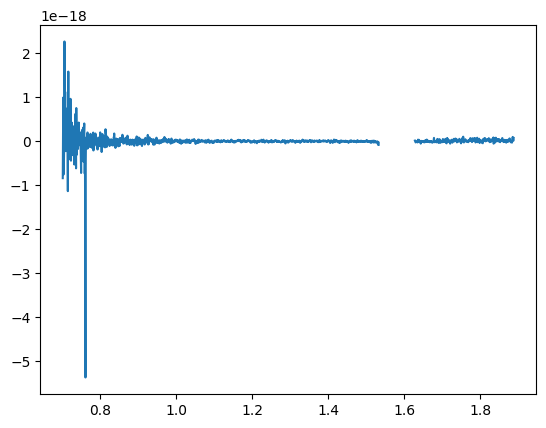

In [103]:
i = 5
plt.plot (df_concat['WAVELENGTH'][i], df_concat['FLUX'][i])

In [104]:
df_concat['WAVELENGTH'] = df_concat['WAVELENGTH'].interpolate(method='linear', limit_direction='both')


/var/folders/4p/2g870fps1s16m6ggm5f64thm0000gn/T/ipykernel_2957/4069024440.py:1: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_concat['WAVELENGTH'] = df_concat['WAVELENGTH'].interpolate(method='linear', limit_direction='both')


In [105]:
df_concat

,file_name,WAVELENGTH,FLUX,FLUX_ERR,nan_in_flux,nan_in_flux_err,flux_nan_position,flux_err_nan_position
0,hlsp_jades_jwst_nirspec_goods-s-mediumhst-0003...,"[0.7, 0.7006363639999998, 0.7012727279999998, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",113,113,middle_nans,middle_nans
1,hlsp_jades_jwst_nirspec_goods-n-mediumhst-0002...,"[0.7, 0.700636364, 0.701272728, 0.701909092, 0...","[nan, 1.904705971881416e-18, -1.72687355738843...","[nan, 1.779430888631721e-18, 1.093628082287658...",5,5,middle_nans,middle_nans
2,hlsp_jades_jwst_nirspec_goods-n-mediumjwst-000...,"[0.7, 0.7006363639999998, 0.7012727279999998, ...","[nan, 8.839861759660464e-19, 1.561907919706200...","[nan, 7.400520285434298e-19, 5.709756593043696...",155,155,middle_nans,middle_nans
3,hlsp_jades_jwst_nirspec_goods-s-mediumhst-0000...,"[0.7, 0.7006363639999998, 0.7012727279999998, ...","[nan, 4.915879528171848e-18, -2.16983726468976...","[nan, 1.3665228764058456e-17, 1.45810399650653...",158,158,middle_nans,middle_nans
4,hlsp_jades_jwst_nirspec_goods-s-mediumjwst-000...,"[0.7, 0.7006363639999998, 0.7012727279999998, ...","[nan, 2.274983177572615e-18, -1.96874427194249...","[nan, 1.7125112421836307e-18, 9.96926796940824...",149,149,middle_nans,middle_nans
...,...,...,...,...,...,...,...,...
10258,hlsp_jades_jwst_nirspec_goods-n-mediumhst-0002...,"[2.87, 2.87179545, 2.8735909, 2.87538635, 2.87...","[nan, -2.1476901093390158e-20, 1.5662190967737...","[nan, 2.0010483067320022e-20, 6.74135198482026...",2,2,middle_nans,middle_nans
10259,hlsp_jades_jwst_nirspec_goods-s-mediumjwst1180...,"[2.87, 2.87179545, 2.8735909, 2.87538635, 2.87...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",31,31,middle_nans,middle_nans
10260,hlsp_jades_jwst_nirspec_goods-s-mediumjwst-000...,"[2.87, 2.87179545, 2.8735909, 2.87538635, 2.87...","[nan, -3.43791779725972e-20, 7.152340459961781...","[nan, 2.3103921611759073e-20, 4.42367310243880...",2,2,middle_nans,middle_nans
10261,hlsp_jades_jwst_nirspec_goods-s-mediumhst-0004...,"[2.87, 2.87179545, 2.8735909, 2.87538635, 2.87...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",135,135,middle_nans,middle_nans


In [108]:
df_concat['FLUX'] = df_concat['FLUX'].interpolate(method='linear', x = df_concat['WAVELENGTH'], limit_direction='both')
df_concat['FLUX'] = df_concat['FLUX'].fillna(method='ffill').fillna(method='bfill')



/var/folders/4p/2g870fps1s16m6ggm5f64thm0000gn/T/ipykernel_2957/4191785005.py:1: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_concat['FLUX'] = df_concat['FLUX'].interpolate(method='linear', x = df_concat['WAVELENGTH'], limit_direction='both')
/var/folders/4p/2g870fps1s16m6ggm5f64thm0000gn/T/ipykernel_2957/4191785005.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_concat['FLUX'] = df_concat['FLUX'].fillna(method='ffill').fillna(method='bfill')


In [109]:
df_concat

,file_name,WAVELENGTH,FLUX,FLUX_ERR,nan_in_flux,nan_in_flux_err,flux_nan_position,flux_err_nan_position
0,hlsp_jades_jwst_nirspec_goods-s-mediumhst-0003...,"[0.7, 0.7006363639999998, 0.7012727279999998, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",113,113,middle_nans,middle_nans
1,hlsp_jades_jwst_nirspec_goods-n-mediumhst-0002...,"[0.7, 0.700636364, 0.701272728, 0.701909092, 0...","[nan, 1.904705971881416e-18, -1.72687355738843...","[nan, 1.779430888631721e-18, 1.093628082287658...",5,5,middle_nans,middle_nans
2,hlsp_jades_jwst_nirspec_goods-n-mediumjwst-000...,"[0.7, 0.7006363639999998, 0.7012727279999998, ...","[nan, 8.839861759660464e-19, 1.561907919706200...","[nan, 7.400520285434298e-19, 5.709756593043696...",155,155,middle_nans,middle_nans
3,hlsp_jades_jwst_nirspec_goods-s-mediumhst-0000...,"[0.7, 0.7006363639999998, 0.7012727279999998, ...","[nan, 4.915879528171848e-18, -2.16983726468976...","[nan, 1.3665228764058456e-17, 1.45810399650653...",158,158,middle_nans,middle_nans
4,hlsp_jades_jwst_nirspec_goods-s-mediumjwst-000...,"[0.7, 0.7006363639999998, 0.7012727279999998, ...","[nan, 2.274983177572615e-18, -1.96874427194249...","[nan, 1.7125112421836307e-18, 9.96926796940824...",149,149,middle_nans,middle_nans
...,...,...,...,...,...,...,...,...
10258,hlsp_jades_jwst_nirspec_goods-n-mediumhst-0002...,"[2.87, 2.87179545, 2.8735909, 2.87538635, 2.87...","[nan, -2.1476901093390158e-20, 1.5662190967737...","[nan, 2.0010483067320022e-20, 6.74135198482026...",2,2,middle_nans,middle_nans
10259,hlsp_jades_jwst_nirspec_goods-s-mediumjwst1180...,"[2.87, 2.87179545, 2.8735909, 2.87538635, 2.87...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",31,31,middle_nans,middle_nans
10260,hlsp_jades_jwst_nirspec_goods-s-mediumjwst-000...,"[2.87, 2.87179545, 2.8735909, 2.87538635, 2.87...","[nan, -3.43791779725972e-20, 7.152340459961781...","[nan, 2.3103921611759073e-20, 4.42367310243880...",2,2,middle_nans,middle_nans
10261,hlsp_jades_jwst_nirspec_goods-s-mediumhst-0004...,"[2.87, 2.87179545, 2.8735909, 2.87538635, 2.87...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",135,135,middle_nans,middle_nans
